In [1]:
import pandas as pd 
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler


In [2]:
# Read data 

df = pd.read_csv(r'C:\Users\User\Documents\Singapore Institute of Management - Bachelor\CSCI316 - Big Data Mining Techniques and Implementation\Group Assignment\Group Assignment 1/data.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_8600\2932465388.py:3: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\User\Documents\Singapore Institute of Management - Bachelor\CSCI316 - Big Data Mining Techniques and Implementation\Group Assignment\Group Assignment 1/data.csv')


In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Data discovery

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           855969 non-null  int64  
 1   member_id                    855969 non-null  int64  
 2   loan_amnt                    855969 non-null  int64  
 3   funded_amnt                  855969 non-null  int64  
 4   funded_amnt_inv              855969 non-null  float64
 5   term                         855969 non-null  object 
 6   int_rate                     855969 non-null  float64
 7   installment                  855969 non-null  float64
 8   grade                        855969 non-null  object 
 9   sub_grade                    855969 non-null  object 
 10  emp_title                    806526 non-null  object 
 11  emp_length                   812908 non-null  object 
 12  home_ownership               855969 non-null  object 
 13 

In [5]:
# Check the null value in each attributes

df.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
total_rev_hi_lim     67313
inq_fi              842681
total_cu_tl         842681
inq_last_12m        842681
default_ind              0
Length: 73, dtype: int64

# Data pre-processing

In [6]:
# total_rev_hi_lim 

# Fill missing values in total_rev_hi_lim with Simple Imputer

imputer = SimpleImputer(strategy='median')
total_rev_hi_lim = df['total_rev_hi_lim'].values.reshape(-1,1)
total_rev_hi_lim_imputed = imputer.fit_transform(total_rev_hi_lim)
df['total_rev_hi_lim'] = total_rev_hi_lim_imputed

In [7]:
# home_ownership 

# Remove rows with value ANY

df = df[df['home_ownership'] != 'ANY']
df['home_ownership'].unique()

# Level encoding for home ownership 

home_type = ['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE']  # Unique values for encoding

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(home_type)

# Encode the 'grade' column in the DataFrame
df['home_ownership'] = encoder.transform(df['home_ownership'])


In [8]:
# Purpose 

# Label encoding for purpose

df['purpose'].unique()

purposes = ['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational']

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(purposes)
# Encode the 'grade' column in the DataFrame
df['purpose'] = encoder.transform(df['purpose'])


In [9]:
# sub_grade

# Sort the order of subgrades and do label encoding

subgrades = ['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5']

def custom_sort_key(subgrade):
    match = re.match(r'([A-Za-z]+)(\d+)', subgrade)
    letter = match.group(1)
    number = int(match.group(2))
    
    return letter, number

sorted_subgrades = sorted(subgrades, key=custom_sort_key)

# Level encoding for sorted sub-grade 

encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(sorted_subgrades)

# Encode the 'grade' column in the DataFrame
df['sub_grade'] = encoder.transform(df['sub_grade'])

In [10]:
# employment_lengths

employment_lengths = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', 'nan']

label_encoder = LabelEncoder()

# Fit the LabelEncoder with unique values
label_encoder.fit(employment_lengths)

# Encode the attribute values
df['emp_length'] = label_encoder.transform(df['emp_length'])

In [11]:
# mths_since_last_delinq

df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(-1)

In [12]:
# mths_since_last_record

df['mths_since_last_record'] = df['mths_since_last_record'].fillna(-1)

In [13]:
# revol_util
# Handle missing value with imputer

imputer = SimpleImputer(strategy='mean')

revol_util = df['revol_util'].values.reshape(-1,1)

revol_util_imputed = imputer.fit_transform(revol_util)

df['revol_util'] = revol_util_imputed

In [14]:
# aggregate annual_inc and annual_inc_joint

df.loc[df['application_type'] == 'JOINT', 'annual_inc'] = df.loc[df['application_type'] == 'JOINT', 'annual_inc_joint']
df = df.drop('annual_inc_joint', axis=1)

In [15]:
# dti_joint

df.loc[df['application_type'] == 'JOINT', 'dti'] = df.loc[df['application_type'] == 'JOINT', 'dti_joint']
df = df.drop('dti_joint', axis=1)

In [16]:
# verification_status_joint

df.loc[df['application_type'] == 'JOINT', 'verification_status'] = df.loc[df['application_type'] == 'JOINT', 'verification_status_joint']
df = df.drop('verification_status_joint', axis=1)

In [17]:
# term 
# Label encoding for term

term = [' 36 months', ' 60 months']  # Unique values for encoding

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(term)

# Encode the 'grade' column in the DataFrame
df['term'] = encoder.transform(df['term'])

In [18]:
# verification_status

veri = ['Not Verified', 'Source Verified', 'Verified']  # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(veri)


df['verification_status'] = encoder.transform(df['verification_status'])

In [19]:
# pymnt_plan

plan = ['n', 'y']  # Unique values for encoding

encoder = LabelEncoder()
encoder.fit(plan)
df['pymnt_plan'] = encoder.transform(df['pymnt_plan'])

In [20]:
# application_type

type = ['INDIVIDUAL', 'JOINT'] # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(type)

df['application_type'] = encoder.transform(df['application_type'])

In [21]:

# initial_list_status

status = ['f', 'w'] # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(status)

df['initial_list_status'] = encoder.transform(df['initial_list_status'])

In [22]:
# Fill missing last credit pull
df['last_credit_pull_d'].fillna("01-01-2016", inplace=True)

In [23]:
# Credit History Length:
# Calculated as: last_credit_pull - earliest_cr_line
def date_difference(date_str1, date_str2):
    # Convert date strings to datetime objects
    date_format = "%d-%m-%Y"
    date1 = datetime.strptime(date_str1, date_format)
    date2 = datetime.strptime(date_str2, date_format)

    # Calculate the difference
    difference = date2 - date1

    # Return the difference in days
    return difference.days

df['credit_history_length'] = df.apply(lambda row: date_difference(row['earliest_cr_line'], row['last_credit_pull_d']), axis=1)

# Swap the values and column names
df['default_ind'], df['credit_history_length'] = df['credit_history_length'], df['default_ind']
df.rename(columns={'default_ind': 'credit_history_length', 'credit_history_length': 'default_ind'}, inplace=True)


In [24]:
# Drop not usable attributes 

remove_col = [
    'id',
    'member_id',
    'emp_title',
    'issue_d',
    'desc',
    'title',
    'zip_code',
    'addr_state',
    'earliest_cr_line',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'collections_12_mths_ex_med',
    'mths_since_last_major_derog',
    'policy_code',
    'tot_coll_amt',
    'tot_cur_bal', 
    'open_acc_6m',
    'open_il_6m', 
    'open_il_12m', 
    'open_il_24m', 
    'mths_since_rcnt_il', 
    'total_bal_il', 
    'il_util', 
    'open_rv_12m' ,
    'open_rv_24m', 
    'max_bal_bc', 
    'all_util', 
    'inq_fi', 
    'total_cu_tl', 
    'inq_last_12m',
    'grade'
]

df = df.drop(remove_col, axis=1)

In [25]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,application_type,acc_now_delinq,total_rev_hi_lim,credit_history_length,default_ind
0,5000,5000,4975.0,0,10.65,162.87,6,1,4,24000.0,...,5000.00,861.07,0.00,0.00,0.00,0,0,23800.0,11322,0
1,2500,2500,2500.0,1,15.27,59.83,13,10,4,30000.0,...,456.46,435.17,0.00,117.08,1.11,0,0,23800.0,5267,1
2,2400,2400,2400.0,0,15.96,84.33,14,1,4,12252.0,...,2400.00,603.65,0.00,0.00,0.00,0,0,23800.0,5174,0
3,10000,10000,10000.0,0,13.49,339.31,10,1,4,49200.0,...,10000.00,2209.33,16.97,0.00,0.00,0,0,23800.0,6909,0
4,3000,3000,3000.0,1,12.69,67.79,9,0,4,80000.0,...,2233.10,1009.07,0.00,0.00,0.00,0,0,23800.0,7305,0


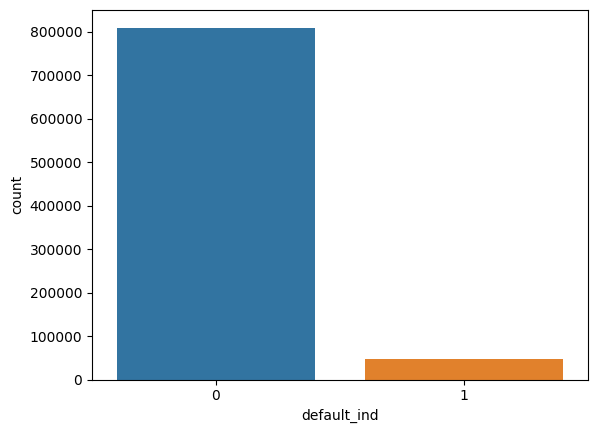

In [26]:
# Visualize default_ind attribute

sns.countplot(data=df, x='default_ind')
plt.show()

## New feature using user defined transformer

In [27]:
class CreditUtilizationRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, include=True):
        self.revol_bal_col = 'revol_bal'
        self.annual_inc_col = 'annual_inc'
        self.installment_col = 'installment'
        self.total_rec_prncp_col = 'total_rec_prncp'
        self.funded_amnt_col = 'funded_amnt'

        self.include_rev_to_inc_ratio = include
        self.include_loan_to_inc_ratio = include
        self.include_repayment_progress = include


    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Find index of columns
        revol_bal_ix = np.where(X.columns == self.revol_bal_col)[0][0]
        annual_inc_ix = np.where(X.columns == self.annual_inc_col)[0][0]
        installment_ix = np.where(X.columns == self.installment_col)[0][0]
        total_rec_prncp_ix = np.where(X.columns == self.total_rec_prncp_col)[0][0]
        funded_amnt_ix = np.where(X.columns == self.funded_amnt_col)[0][0]

        # Calculate the Revolving Credit Balance to Annual Income Ratio.
        rev_to_inc_ratio = X.iloc[:, revol_bal_ix] / X.iloc[:, annual_inc_ix]

        # Calculate the Loan Payment-to-Income Ratio.
        loan_to_inc_ratio = X.iloc[:, installment_ix] / (X.iloc[:, annual_inc_ix] / 12)

        # Calculate the Repayment Progress.
        repayment_progress = (X.iloc[:, total_rec_prncp_ix] / X.iloc[:, funded_amnt_ix]) * 100

        # Create a copy of the original DataFrame to avoid modifying it directly
        X_transformed = X.copy()

        # Add the new columns to the DataFrame using .loc
        if self.include_rev_to_inc_ratio:
            X_transformed.loc[:, 'Rev_to_Inc_Ratio'] = rev_to_inc_ratio

        if self.include_loan_to_inc_ratio:
            X_transformed.loc[:, 'Loan_Payment_to_Income_Ratio'] = loan_to_inc_ratio

        if self.include_repayment_progress:
            X_transformed.loc[:, 'Repayment_Progress'] = repayment_progress

        return X_transformed


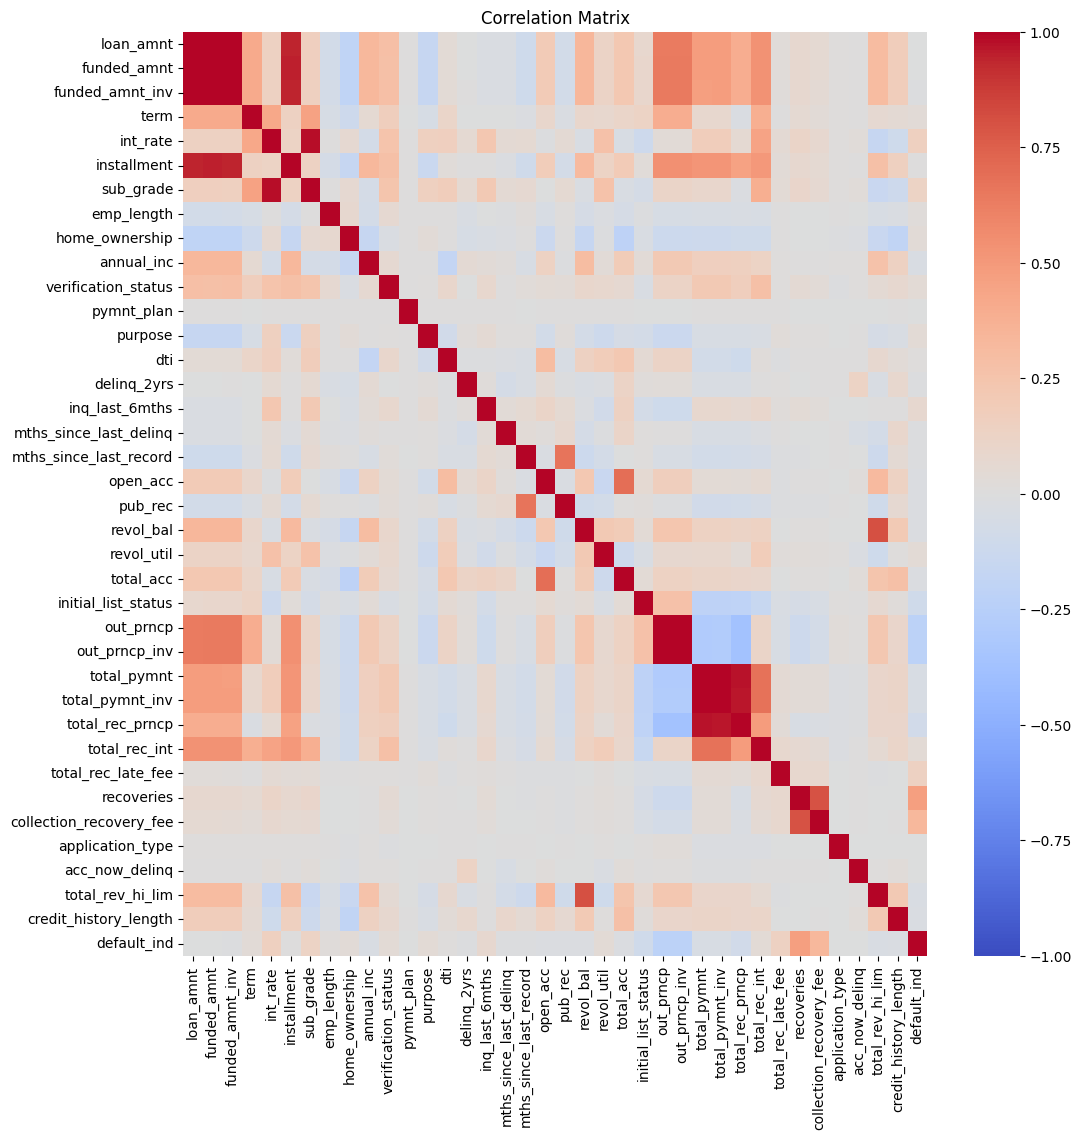

In [28]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = df.corr()

# Select the correlation values with 'default_ind'
target_corr = corr_matrix['default_ind']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

# Model selection and training

# K-Nearest Neighbors (KNN) Model 

# 1) Fresh round of training

### 1a: Feature selection

In [29]:
# Define the features (subset of columns from the original dataset)
selected_features = ['recoveries', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'sub_grade', 'revol_bal', 'annual_inc', 'installment', 'total_rec_prncp', 'funded_amnt']

# Create the feature matrix X by selecting the columns from the original dataset
X_beforeTransformed= df[selected_features]
y = df['default_ind']

### 1b: StratifiedShuffleSplit Sampling

In [30]:
# Instantiate the StratifiedShuffleSplit object
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split and obtain the indices for training and testing sets
for train_index, test_index in stratified_shuffle_split.split(X_beforeTransformed, y):
    KNN_X_train, KNN_X_test = X_beforeTransformed.iloc[train_index], X_beforeTransformed.iloc[test_index]
    KNN_y_train, KNN_y_test = y.iloc[train_index], y.iloc[test_index]


#### Visualisation of Test and Train shape

In [31]:
print("KNN_X_train shape:", KNN_X_train.shape)
print("KNN_X_test shape:", KNN_X_test.shape)
print("KNN_y_train shape:", KNN_y_train.shape)
print("KNN_y_test shape:", KNN_y_test.shape)

KNN_X_train shape: (684772, 10)
KNN_X_test shape: (171194, 10)
KNN_y_train shape: (684772,)
KNN_y_test shape: (171194,)


#### Result: Significantly imbalanced class distribution

#### Solution: Have to apply class balancing techniques (e.g. oversampling/SMOTE, or Class-Weighted approach) just before Model training



### 1c: Basic K-Neighbour Model training

In [32]:
#  set the weights parameter to 'distance'
# 'distance' means weights are assigned based on the inverse of the distance
KNN_basic_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Train the classifier on the training data with class weights
KNN_basic_classifier.fit(KNN_X_train, KNN_y_train)

# Make predictions on the testing data
KNN_basic_y_pred = KNN_basic_classifier.predict(KNN_X_test)

# 2) Fine tune the model

### 2a: + User-defined Transformer Features to X

In [33]:
# Create an instance of CreditUtilizationRatioTransformer with desired features included
transformer = CreditUtilizationRatioTransformer(
    include= True
)
# Apply the transformer to add the new features to X
X_transformed = transformer.transform(X_beforeTransformed)

# Now X contains the original selected features along with additional features from the transformer


#### StratifiedShuffleSplit Re-Sampling

In [34]:
# Instantiate the StratifiedShuffleSplit object
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split and obtain the indices for training and testing sets
for train_index, test_index in stratified_shuffle_split.split(X_transformed, y):
    KNN_Balanced_X_train, KNN_Balanced_X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
    KNN_Balanced_y_train, KNN_Balanced_y_test = y.iloc[train_index], y.iloc[test_index]


#### Visualisation of Test and Train shape

In [35]:
print("KNN_Balanced_X_train shape:", KNN_Balanced_X_train.shape)
print("KNN_Balanced_X_test shape:", KNN_Balanced_X_test.shape)
print("KNN_Balanced_y_train shape:", KNN_Balanced_y_train.shape)
print("KNN_Balanced_y_test shape:", KNN_Balanced_y_test.shape)

KNN_Balanced_X_train shape: (684772, 13)
KNN_Balanced_X_test shape: (171194, 13)
KNN_Balanced_y_train shape: (684772,)
KNN_Balanced_y_test shape: (171194,)


### 2b: Hyperparameter

#### Finding the nearest n_neighbour

In [36]:
# Define the range of n_neighbors to test
param_grid = {'n_neighbors': range(1, 21)}

# Initialize the KNN classifier
KNNclassifier = KNeighborsClassifier(weights='distance')

# Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning
# For GridSearchCV:
grid_search = GridSearchCV(KNNclassifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(KNN_Balanced_X_train, KNN_Balanced_y_train)

# For RandomizedSearchCV:
# randomized_search = RandomizedSearchCV(classifier, param_distributions=param_grid, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
# randomized_search.fit(KNN_Balanced_X_train, KNN_Balanced_y_train)

# Print the best hyperparameters and the corresponding performance
print("Best n_neighbors:", grid_search.best_params_['n_neighbors'])
print("Best Accuracy:", grid_search.best_score_)


Best n_neighbors: 4
Best Accuracy: 0.994078321001961


### 2c: Training KNN Model using SMOTE approach


In [37]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=42)

# Perform SMOTE only on the training data
X_train_balanced, y_train_balanced = smote.fit_resample(KNN_Balanced_X_train, KNN_Balanced_y_train)


#### Visualising Data Shape Before and After SMOTE

In [38]:
# Before SMOTE
print("Class distribution before SMOTE:")
print(pd.Series(KNN_Balanced_y_train).value_counts())

# After SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution before SMOTE:
default_ind
0    647598
1     37174
Name: count, dtype: int64
Class distribution after SMOTE:
default_ind
0    647598
1    647598
Name: count, dtype: int64


#### Training Model

In [39]:
# Train the classifier on the training data with SMOTE
KNN_classifier_smote = KNeighborsClassifier(n_neighbors=4)
KNN_classifier_smote.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier(n_neighbors=4)

In [40]:
# Make predictions on the test set using the trained model
KNN_smote_y_pred = KNN_classifier_smote.predict(KNN_Balanced_X_test)

# Calculate evaluation metrics for the test set
accuracy_smote = accuracy_score(KNN_Balanced_y_test, KNN_smote_y_pred)
roc_auc_smote = roc_auc_score(KNN_Balanced_y_test, KNN_smote_y_pred)

### 2d: Training KNN Model using Class-Weighted approach

#### Training  Model 

In [41]:
#  set the weights parameter to 'distance'
# 'distance' means weights are assigned based on the inverse of the distance
class_classifier = KNeighborsClassifier(n_neighbors=4, weights='distance')

# Train the classifier on the training data with class weights
class_classifier.fit(KNN_Balanced_X_train, KNN_Balanced_y_train)


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [42]:
# Make predictions on the testing data
KNN_class_y_pred = class_classifier.predict(KNN_Balanced_X_test)

# Calculate evaluation metrics
class_accuracy = accuracy_score(KNN_Balanced_y_test, KNN_class_y_pred)
roc_auc = roc_auc_score(KNN_Balanced_y_test, KNN_class_y_pred)


# 3) Evaluate the outcome

#### 3a: Comparison

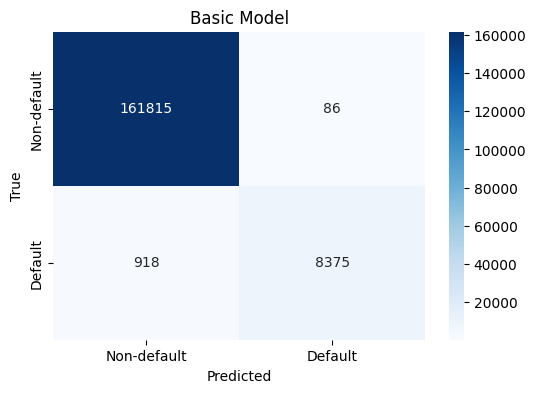

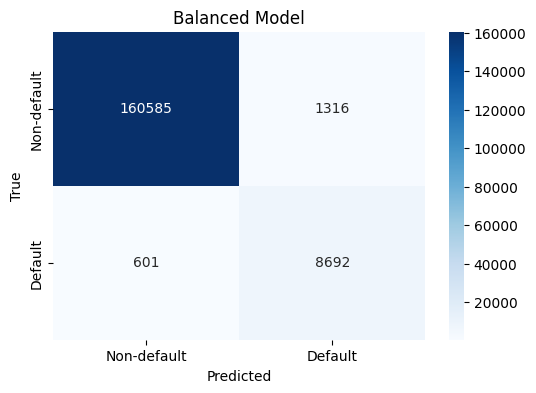

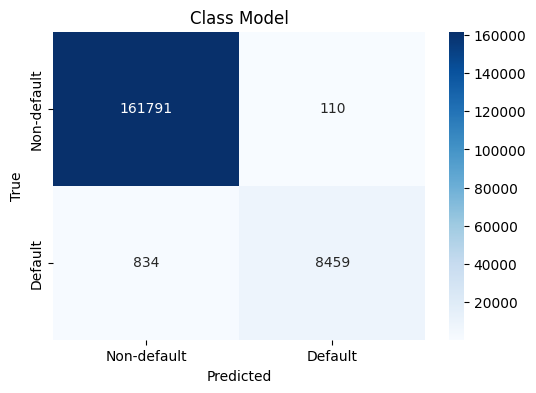

            Model  Accuracy  ROC-AUC Score  Precision (Non-default)  \
0     Basic Model  0.994135       0.950342                 0.994359   
1  Balanced Model  0.988802       0.963600                 0.996271   
2     Class Model  0.994486       0.954788                 0.994872   

   Recall (Non-default)  F1-score (Non-default)  Precision (Default)  \
0              0.999469                0.996907             0.989836   
1              0.991872                0.994067             0.868505   
2              0.999321                0.997091             0.987163   

   Recall (Default)  F1-score (Default)  
0          0.901216            0.943449  
1          0.935328            0.900679  
2          0.910255            0.947150  


In [43]:
def evaluate_predictions(y_true, y_pred, model_name):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Non-default', 'Default'], output_dict=True)

    # Create a summary table
    summary_table = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'ROC-AUC Score': [roc_auc],
        'Precision (Non-default)': [report['Non-default']['precision']],
        'Recall (Non-default)': [report['Non-default']['recall']],
        'F1-score (Non-default)': [report['Non-default']['f1-score']],
        'Precision (Default)': [report['Default']['precision']],
        'Recall (Default)': [report['Default']['recall']],
        'F1-score (Default)': [report['Default']['f1-score']],
    })

    return summary_table

# Usage:
basic_summary = evaluate_predictions(KNN_Balanced_y_test, KNN_basic_y_pred, "Basic Model")
smote_summary = evaluate_predictions(KNN_Balanced_y_test, KNN_smote_y_pred, "Balanced Model")
class_summary = evaluate_predictions(KNN_Balanced_y_test, KNN_class_y_pred, "Class Model")

# Combine all summaries into one DataFrame
all_summaries = pd.concat([basic_summary, smote_summary, class_summary], ignore_index=True)

# Display the summary table
print(all_summaries)


#### 3b: Conclusion: Since Class-Weighted approach have better scores across almost all metrics, therefore it is best to use this approach

# Decision Tree Model


### 1. Fresh Round of Training

#### 1a: Feature Selection

In [44]:
# Define the features (subset of columns from the original dataset)
DT_selected_features = [
    'collection_recovery_fee'   ,                  
    'acc_now_delinq' ,                                    
    'funded_amnt'   ,               
    'funded_amnt_inv'   ,            
    'mths_since_last_record' ,       
    'delinq_2yrs'   ,                          
    'dti'            ,              
    'mths_since_last_delinq'  ,       
    'emp_length',                      
    'pub_rec'   ,                  
    'revol_bal'    ,                                
    'credit_history_length'  ,        
    'term'   ,                       
    'home_ownership' ,                                
    'total_rev_hi_lim'  ,              
    'total_pymnt'      ,                     
    'total_pymnt_inv'  ,              
    'purpose'   ,                   
    'revol_util'   ,                 
    'total_rec_int'   ,               
    'inq_last_6mths'  ,              
    'total_rec_prncp' ,                        
    'sub_grade'        ,             
    'total_rec_late_fee'   ,          
    'int_rate'   ,                    
    'out_prncp_inv'  ,                 
    'out_prncp'   ,                       
    'recoveries'      ,
    'annual_inc'    ,
    'installment'

]

# Create the feature matrix X by selecting the columns from the original dataset
DT_X_before_transforming = df[DT_selected_features]
DT_y = df['default_ind']

#### 1b: StratifiedShuffleSplit Sampling

In [45]:
# Instantiate the StratifiedShuffleSplit object
DT_stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split and obtain the indices for training and testing sets
for DT_train_index, DT_test_index in DT_stratified_shuffle_split.split(DT_X_before_transforming, DT_y):
    DT_X_train, DT_X_test = DT_X_before_transforming.iloc[DT_train_index], DT_X_before_transforming.iloc[DT_test_index]
    DT_y_train, DT_y_test = DT_y.iloc[DT_train_index], DT_y.iloc[DT_test_index]


Visualisation of Test and Train shape

In [46]:

print("DT_X_train shape:", DT_X_train.shape)
print("DT_X_test shape:", DT_X_test.shape)
print("DT_y_train shape:", DT_y_train.shape)
print("DT_y_test shape:", DT_y_test.shape)


DT_X_train shape: (684772, 30)
DT_X_test shape: (171194, 30)
DT_y_train shape: (684772,)
DT_y_test shape: (171194,)


The class distribution is significantly imbalance. 
Class balancing technique such as SMOTE and class-weighted is used.

#### 1c: Basic Decision Tree Model Training

In [47]:
# Create a Decision Tree Classifier with random state = 42
DT_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier
DT_classifier.fit(DT_X_train, DT_y_train)

# Make predictions on the test set
DT_y_pred = DT_classifier.predict(DT_X_test)

# Evaluate the model
DT_basic_accuracy = accuracy_score(DT_y_test, DT_y_pred)
print("Accuracy:", DT_basic_accuracy)

Accuracy: 0.9954320829001017


### 2. Fine tune DT model

#### 2a: Add User-Defined Transformer Features to X 

In [48]:
# Create an instance of CreditUtilizationRatioTransformer with desired features included
DT_transformer = CreditUtilizationRatioTransformer(include = True)

# Apply the transformer to add the new features to X
DT_X_after_transforming = DT_transformer.transform(DT_X_before_transforming)

# Now X contains the original selected features along with additional features from the transformer

#### 2b: StratifiedShuffleSplit Re-Sampling

In [49]:
# Instantiate the StratifiedShuffleSplit object
DT_stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split and obtain the indices for training and testing sets
for DT_train_index, DT_test_index in DT_stratified_shuffle_split.split(DT_X_after_transforming, DT_y):
    DT_Balanced_X_train, DT_Balanced_X_test = DT_X_after_transforming.iloc[DT_train_index], DT_X_after_transforming.iloc[DT_test_index]
    DT_Balanced_y_train, DT_Balanced_y_test = DT_y.iloc[DT_train_index], DT_y.iloc[DT_test_index]

Visualisation of Test and Train shape

In [50]:

print("DT_Balanced_X_train shape:", DT_Balanced_X_train.shape)
print("DT_Balanced_X_test shape:", DT_Balanced_X_test.shape)
print("DT_Balanced_y_train shape:", DT_Balanced_y_train.shape)
print("DT_Balanced_y_test shape:", DT_Balanced_y_test.shape)

DT_Balanced_X_train shape: (684772, 33)
DT_Balanced_X_test shape: (171194, 33)
DT_Balanced_y_train shape: (684772,)
DT_Balanced_y_test shape: (171194,)


#### 2c: Training Decision Tree Model with hyperparameters

In [51]:
# Create a Decision Tree Classifier with class-weighted training
DT_classifier = DecisionTreeClassifier(criterion='entropy',splitter = 'best', max_depth = 10, min_samples_split = 10, min_samples_leaf = 4, class_weight='balanced', random_state=42)

# Train the classifier
DT_classifier.fit(DT_Balanced_X_train, DT_Balanced_y_train)

# Make predictions on the test set
DT_y_pred = DT_classifier.predict(DT_Balanced_X_test)

# Evaluate the model
DT_hyperparameter_accuracy = accuracy_score(DT_Balanced_y_test, DT_y_pred)
print("Accuracy training with hyperparameters:", DT_hyperparameter_accuracy)


Accuracy training with hyperparameters: 0.9972721006577333


#### 2d: Training Decision Tree Model using SMOTE

In [52]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=42)

# Perform SMOTE only on the training data
DT_Balanced_X_train_SMOTE, DT_Balanced_y_train_SMOTE = smote.fit_resample(DT_Balanced_X_train, DT_Balanced_y_train)

#### Visualising Data Shape Before and After SMOTE

In [53]:
# Before SMOTE
print("Class distribution before SMOTE:")
print(pd.Series(DT_Balanced_y_train).value_counts())

# After SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(DT_Balanced_y_train_SMOTE).value_counts())

Class distribution before SMOTE:
default_ind
0    647598
1     37174
Name: count, dtype: int64
Class distribution after SMOTE:
default_ind
0    647598
1    647598
Name: count, dtype: int64


#### Training model

In [54]:
# Train the classifier on the training data with SMOTE
classifier_smote = DecisionTreeClassifier(criterion='entropy',splitter = 'best', max_depth = 10, min_samples_split = 10, min_samples_leaf = 4, class_weight='balanced', random_state=42)
classifier_smote.fit(DT_Balanced_X_train_SMOTE, DT_Balanced_y_train_SMOTE)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

In [55]:
# Make predictions on the test set using the trained model
DT_y_pred_smote = classifier_smote.predict(DT_Balanced_X_test)

# Evaluate the model
DT_smote_accuracy = accuracy_score(DT_Balanced_y_test, DT_y_pred_smote)
print("Accuracy:", DT_smote_accuracy)

Accuracy: 0.9979146465413508


#### 2e: Training Decision Tree Model using Class-Weighted

In [56]:
# Train the classifier on the training data with class-weighted
DT_classifier_class_weighted = DecisionTreeClassifier(criterion='entropy',splitter = 'best', max_depth = 10, min_samples_split = 10, min_samples_leaf = 4, class_weight='balanced', random_state=42)
DT_classifier_class_weighted.fit(DT_Balanced_X_train, DT_Balanced_y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

In [57]:
# Make predictions on the test set
DT_y_pred_class = DT_classifier_class_weighted.predict(DT_Balanced_X_test)

# Evaluate the model
DT_class_accuracy = accuracy_score(DT_Balanced_y_test, DT_y_pred_class)
print("Accuracy using class weighted:", DT_class_accuracy)

Accuracy using class weighted: 0.9972721006577333


#### 2f: Training Decision Tree Model with post-pruning

In [59]:

# Apply post-pruning by varying ccp_alpha
ccp_alphas = np.arange(0.0, 0.01, 0.001)
DT_best_accuracy = 0.0
DT_best_f1_score = 0.0
DT_best_alpha = 0.0

for alpha in ccp_alphas:
    dt_pruned = DecisionTreeClassifier(criterion='entropy',splitter = 'best', max_depth = 10, min_samples_split = 10, min_samples_leaf = 4, class_weight='balanced', random_state=42)
    dt_pruned.fit(DT_Balanced_X_train, DT_Balanced_y_train)
    DT_y_pred = dt_pruned.predict(DT_Balanced_X_test)
    DT_accuracy = accuracy_score(DT_Balanced_y_test, DT_y_pred)
    DT_f1_score_weighted = f1_score(DT_Balanced_y_test, DT_y_pred, average='weighted')
    
    if DT_f1_score_weighted > DT_best_f1_score:
        DT_best_f1_score = DT_f1_score_weighted
        DT_best_accuracy = DT_accuracy
        DT_best_alpha = alpha

print("Best CCP Alpha:", DT_best_alpha)
print("Best Accuracy:", DT_best_accuracy)
print("Best Weighted F1 Score:", DT_best_f1_score)


# The best_dt_pruned contains the Decision Tree classifier with the best ccp_alpha
DT_best_dt_pruned = DecisionTreeClassifier(criterion='entropy',splitter = 'best', max_depth = 10, min_samples_split = 10, min_samples_leaf = 4, class_weight='balanced', random_state=42)
DT_best_dt_pruned.fit(DT_Balanced_X_train, DT_Balanced_y_train)

# Make predictions on the test set using the pruned tree
DT_y_pred_pruned = DT_best_dt_pruned.predict(DT_Balanced_X_test)

# Evaluate the model
DT_post_pruning_accuracy = accuracy_score(DT_Balanced_y_test, DT_y_pred_pruned)
print("Accuracy:", DT_post_pruning_accuracy)

# Perform evaluation or other tasks with the pruned model as needed

Best CCP Alpha: 0.0
Best Accuracy: 0.9972721006577333
Best Weighted F1 Score: 0.9972746546672799
Accuracy: 0.9972721006577333


### 3. Evaluate the best model


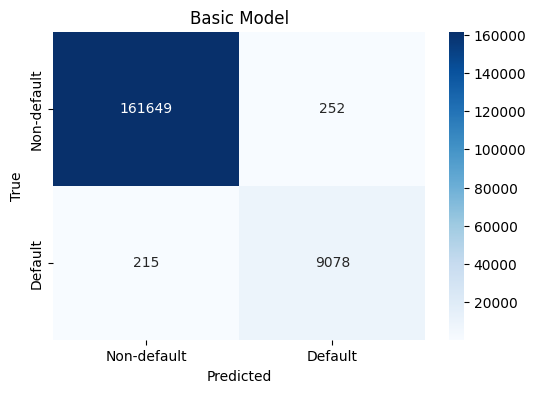

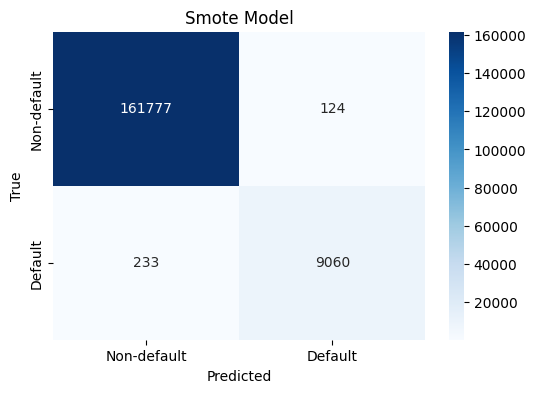

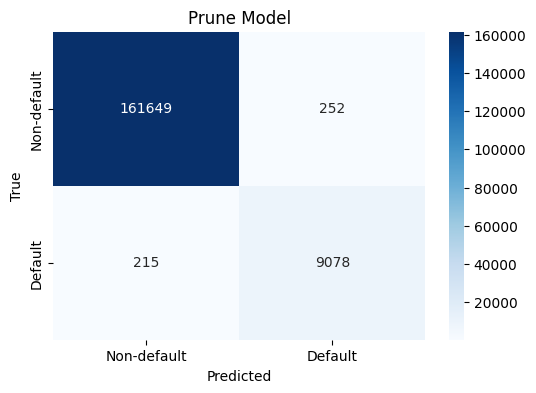

         Model  Accuracy  ROC-AUC Score  Precision (Non-default)  \
0  Basic Model  0.997272       0.987654                 0.998672   
1  Smote Model  0.997915       0.987081                 0.998562   
2  Prune Model  0.997272       0.987654                 0.998672   

   Recall (Non-default)  F1-score (Non-default)  Precision (Default)  \
0              0.998443                0.998558             0.972990   
1              0.999234                0.998898             0.986498   
2              0.998443                0.998558             0.972990   

   Recall (Default)  F1-score (Default)  
0          0.976864            0.974923  
1          0.974927            0.980679  
2          0.976864            0.974923  


In [60]:
def evaluate_predictions(y_true, y_pred, model_name):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Non-default', 'Default'], output_dict=True)

    # Create a summary table
    summary_table = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'ROC-AUC Score': [roc_auc],
        'Precision (Non-default)': [report['Non-default']['precision']],
        'Recall (Non-default)': [report['Non-default']['recall']],
        'F1-score (Non-default)': [report['Non-default']['f1-score']],
        'Precision (Default)': [report['Default']['precision']],
        'Recall (Default)': [report['Default']['recall']],
        'F1-score (Default)': [report['Default']['f1-score']],
    })

    return summary_table

# Usage:
DT_basic_summary = evaluate_predictions(DT_Balanced_y_test, DT_y_pred, "Basic Model")
DT_smote_summary = evaluate_predictions(DT_Balanced_y_test, DT_y_pred_smote, "Smote Model")
DT_pruned_summary = evaluate_predictions(DT_Balanced_y_test, DT_y_pred_pruned, "Prune Model")

# Combine all summaries into one DataFrame
DT_all_summaries = pd.concat([DT_basic_summary, DT_smote_summary, DT_pruned_summary], ignore_index=True)

# Display the summary table
print(DT_all_summaries)

#### Conclusion: Since Decision Tree using SMOTE have the best scores across almost all metrics, therefore it is best to use this approach